In [2]:
import torch
from torch.utils.data import Subset,DataLoader, TensorDataset, ConcatDataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
batch_size = 64
num_classes = 10
epochs = 10
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [4]:
train_set = datasets.MNIST('/content',train=True,download=True)
test_set = datasets.MNIST('/content',train=False,download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



### Preprocessing

In [5]:
# inversion and normalization
invert = lambda image : 1 - image # function to invert the image
normalize = lambda image : image / 255 # function for bringing pixel values in range [0,1]

def preprocessing(dataset):
    dataset_images = dataset.data.numpy() # convert the dataset into numpy array
    dataset_labels = dataset.targets.numpy() # convert the labels into numpy array
    dataset_images = normalize(dataset_images)
    # dataset_images = invert(dataset_images)
    return dataset_images,dataset_labels

train_images,train_labels = preprocessing(train_set)
test_images,test_labels = preprocessing(test_set)

In [6]:
train_labels.dtype

dtype('int64')

### Define the network

In [7]:
class NeuralNetwork(nn.Module):
  def __init__(self,classes,channels):
    super().__init__()
    self.conv1 = nn.Conv2d(channels,4,5)
    self.conv2 = nn.Conv2d(4,6,5)
    self.pool = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(6*4*4,128)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,classes)
  
  def forward(self,x):
    x = x.unsqueeze(1)
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(x.shape[0],-1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    # x = F.softmax(x,dim=1)
    return x

### Training the model

In [8]:
def train(model,trainloader):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
  model = model.to(device)
  model.train()
  for e in range(epochs):
    running_loss = 0.0
    for _,(images,labels) in enumerate(trainloader):
      images,labels = images.to(device),labels.to(device)
      optimizer.zero_grad()

      output = model(images)
      loss = criterion(output,labels)

      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    # else:
    #   print(f"Training loss: {running_loss / len(trainloader)}")
  return model

### Testing the model

In [9]:
def test(model,testloader,classes=2):
  correct = np.zeros(classes,dtype=np.float64)
  total = np.zeros(classes,dtype=np.float64)
  model = model.to(device)
  with torch.no_grad():
    for images,labels in testloader:
      images,labels = images.to(device),labels.to(device)
      output = model(images)
      pred = torch.argmax(output,dim=1)
      for i in range(len(labels)):
        correct[labels[i]] += (pred[i] == labels[i])
        total[labels[i]] += 1
  # print(f"Accuracy for {classes} classes: {np.sum(correct) / np.sum(total)}")
  return correct[0] / total[0]

### Prepare initial training set

In [13]:
accuracy_changes = []
x = np.linspace(0,10,num=9)
class_of_interest = 0

multi_class_train_images = np.empty((0,28,28),dtype=np.float64)
multi_class_train_labels = []
multi_class_test_images = np.empty((0,28,28),dtype=np.float64)
multi_class_test_labels = []
found = False

for i in range(num_classes):
  # prepare the dataset
  if i == class_of_interest:
    found = True
    for image,label in zip(train_images,train_labels):
      if label == i:
        multi_class_train_images = np.vstack(([multi_class_train_images,[image]]))
        multi_class_train_labels.append(0)

    for image,label in zip(test_images,test_labels):
      if label == i:
        multi_class_test_images = np.vstack(([multi_class_test_images,[image]]))
        multi_class_test_labels.append(0)
  else:
    for image,label in zip(train_images,train_labels):
      if label == i:
        multi_class_train_images = np.vstack((multi_class_train_images,[image]))
        multi_class_train_labels.append(1)
    
    for image,label in zip(test_images,test_labels):
      if label == i:
        multi_class_test_images = np.vstack((multi_class_test_images,[image]))
        multi_class_test_labels.append(1)
  # if target class has been added to dataset by now
  if found and i >= 1:
    train_tensor_x = torch.Tensor(multi_class_train_images)
    train_tensor_y = torch.Tensor(multi_class_train_labels)
    test_tensor_x = torch.Tensor(multi_class_test_images)
    test_tensor_y = torch.Tensor(multi_class_test_labels)
    train_dataset = TensorDataset(train_tensor_x,train_tensor_y.to(torch.int64))
    test_dataset = TensorDataset(test_tensor_x,test_tensor_y.to(torch.int64))

    train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
    test_loader = DataLoader(test_dataset,batch_size=batch_size)

    model = NeuralNetwork(2,1)
    model = train(model,train_loader)
    accuracy = test(model,test_loader)
    print(accuracy)
    accuracy_changes.append(accuracy)





# plt.legend()
# plt.title("Accuracy fluctuation")
# plt.show()

0.9979591836734694
0.9938775510204082
0.9928571428571429
0.9928571428571429
0.9897959183673469
0.9846938775510204
0.9795918367346939
0.9704081632653061
0.9887755102040816


### Plot the accuracy variation for the class of interest


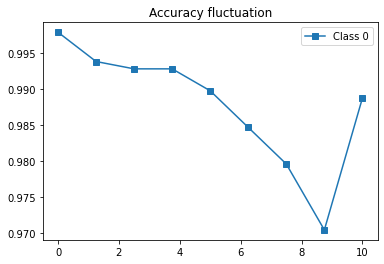

In [14]:
x = np.linspace(0,10,num=9)
plt.plot(x,accuracy_changes,'-s',label = 'Class 0')
# plt.plot(x,accuracy_change_1,'-s',label = 'Class 1')
plt.legend()
plt.title("Accuracy fluctuation")
plt.show()